In [1]:
from scipy.stats import spearmanr
from collections import defaultdict
#from tqdm import tqdm
from utils import get_datasets, get_correlations
import numpy as np
from matplotlib import pyplot as plt
from nudging.dataset import Pennycook1

In [2]:
sim_datasets = get_datasets(n=5000)

In [3]:
sub_results = get_correlations(sim_datasets)

In [12]:
def plot_sub_cates(results):
    plt.figure(dpi=120)
    for model_name, model_res in results.items():
        print(len(model_res["all"]))
        plt.scatter(model_res["all"], model_res["individual"], label=model_name)
        print(model_name, spearmanr(model_res["all"], model_res["individual"]))
    plt.xlabel("subgroup CATE")
    plt.ylabel("individual CATE")
    plt.legend()
    plt.show()

In [5]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

def plot_sub_individual(results, bounds=(0.0, 0.25)):
    a, b = None, None
    data = {}
    for model_name, model_res in results.items():
        x_sub = np.array(model_res["all"])
        y_ind = np.array(model_res["individual"])
        x_idx = np.logical_and(x_sub >= bounds[0], x_sub <= bounds[1])
        x_sub = x_sub[x_idx]
        y_ind = y_ind[x_idx]

        if a is None:
            model = LinearRegression().fit(x_sub.reshape(-1, 1), y_ind)
            a = model.coef_[0]
            b = model.intercept_
        bound_mid = np.mean(bounds)
        y_ind_adj = y_ind + (bound_mid-x_sub)*b
        data[model_name] = y_ind_adj
        #plt.hist(y_ind_adj, label=model_name)
    #plt.legend()
    #plt.show()
    sns.displot(data, kind="kde")

def plot_shift_individual(model_res, delta=0.2):
    x_sub = np.array(model_res["all"])
    y_ind = np.array(model_res["individual"])
    model = LinearRegression().fit(x_sub.reshape(-1, 1), y_ind)
    a = model.coef_[0]
    b = model.intercept_
    data = {}
    for bound_start in np.arange(-0.2, 1, step=delta/2):
        bound_end = bound_start+delta
        bound_mid = (bound_start+bound_end)/2
        x_idx = np.logical_and(x_sub >= bound_start, x_sub <= bound_end)
        data[str(bound_mid)] = y_ind[x_idx] + (bound_mid-x_sub[x_idx])*b
    sns.displot(data, kind="kde")
    plt.show()
    y = np.array([np.mean(x) for x in data.values()])
    x = np.array([float(x) for x in list(data)]).astype(float)
    plt.plot(x, y)
    plt.plot(x, x)
    plt.show()

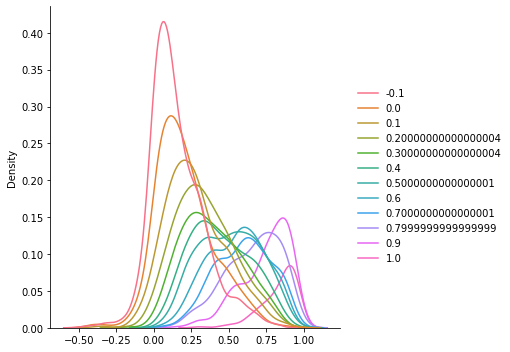

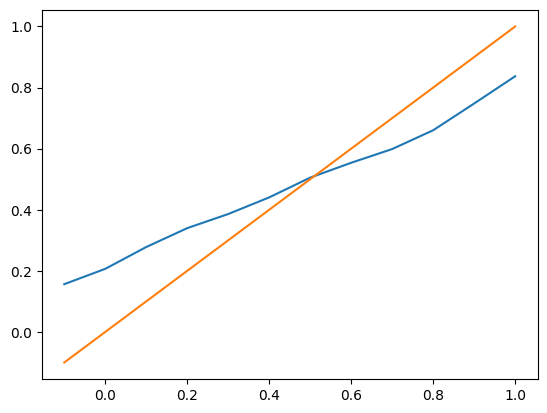

In [6]:
plot_shift_individual(sub_results["t-learner"])

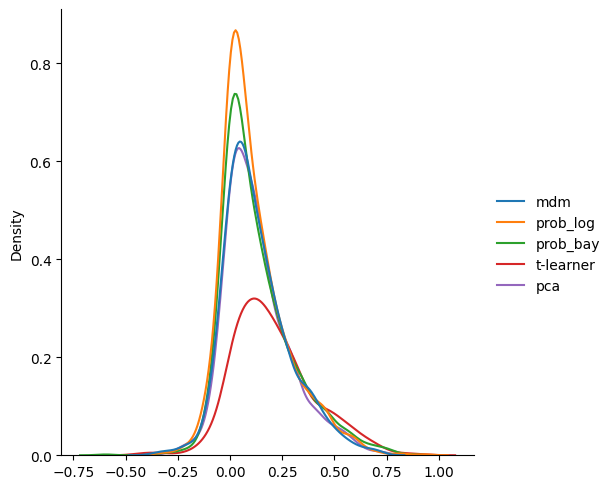

In [7]:
plot_sub_individual(sub_results, bounds=(-0.1, 0.1))

5000
mdm SpearmanrResult(correlation=0.7366084174003367, pvalue=0.0)
5000
prob_log SpearmanrResult(correlation=0.6985006922920276, pvalue=0.0)
5000
prob_bay SpearmanrResult(correlation=0.6936827584630552, pvalue=0.0)
5000
t-learner SpearmanrResult(correlation=0.7597774381693322, pvalue=0.0)
5000
pca SpearmanrResult(correlation=0.724680879163235, pvalue=0.0)


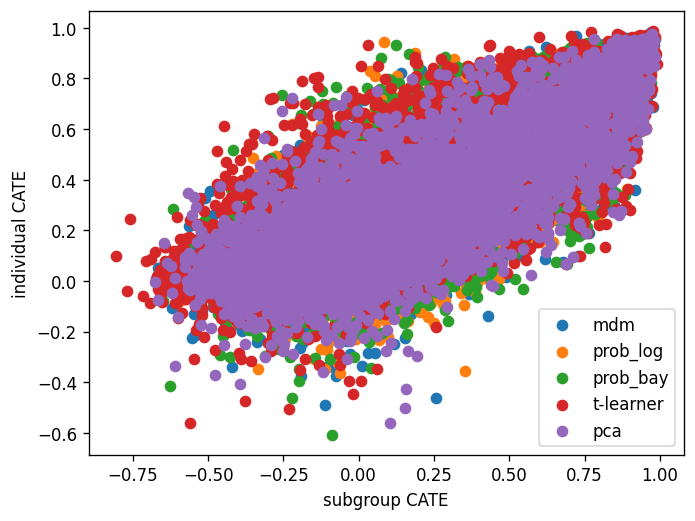

In [13]:
plot_sub_cates(sub_results)

In [9]:
from nudging.dataset import Pennycook1, Pennycook2, Balaban, Lieberoth, Vandenbroele, Hotard

In [10]:
all_data = {
    "penny1": Pennycook1.from_file("data"),
    "penny2": Pennycook2.from_file("data"),
    "balaban": Balaban.from_file("data"),
    "hotard": Hotard.from_file("data"),
    "lieberoth": Lieberoth.from_file("data"),
    "broele": Vandenbroele.from_file("data"),
}

In [11]:
dataset = Pennycook1.from_file("data")
models = {
    "mdm": MDMModel(ARDRegression()),
    "prob_log": ProbModel(LogisticRegression()),
    "prob_bay": ProbModel(ARDRegression()),
    "t-learner": BiRegressor(ARDRegression()),
    "pca": PCAModel(ARDRegression()),
}
for dataset_name, dataset in all_data.items():
    print(f"------ {dataset_name} ------")
    for model_name, model in models.items():
        print(model_name, compute_partition_correlation(model, dataset, KSplitPartitioner, KMeansPartitioner))

NameError: name 'MDMModel' is not defined